# Deep Learning Project
## Team:
###   - Akshay P M          AM.EN.U4CSE20006
###   - Ritik Kumar Singh   AM.EN.U4CSE20061
###   - T Vishnu Sandeep    AM.EN.U4CSE20073
###   - Patel RajKumar P    AM.EN.U4CSE20349

## Motivation:
###  - Create a Custom and efficient CNN Model and hyperparameter tuning Alexnet to classify the various classes present in the Vehicle dataset
#### Two classes Vehicles or Non Vehicles


#For creating split in images
import splitfolders
splitfolders.ratio(input="E:\Codes\Deep Learning CV\Project\Dataset\DPCV_Project 2",
                   output="E:\Codes\Deep Learning CV\Project\Dataset\proj_dataset 2",
                   seed=1337, ratio=(.8, 0.1,0.1),group_prefix=None,move=False)

In [1]:
import os
import cv2
from cv2 import imread, resize
__all__ = [imread, resize]
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from keras import layers,datasets,models
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
from keras_tuner import RandomSearch
from keras_tuner.engine.hyperparameters import HyperParameters

In [2]:
#### Fixing the image sizes
img_size=32

In [3]:
# importing Dataset
vehicle_dir = "E:/Codes/Deep Learning CV/Project/Dataset/DPCV_Project/vehicles"
nonvehicle_dir = "E:/Codes/Deep Learning CV/Project/Dataset/DPCV_Project/non-vehicles"
vehicle = os.listdir(vehicle_dir)
non_vehicle = os.listdir(nonvehicle_dir)

FileNotFoundError: [WinError 3] The system cannot find the path specified: 'E:/Codes/Deep Learning CV/Project/Dataset/DPCV_Project/vehicles'

In [4]:
# loading images and labels into np array
imgs = []
labels = []
import tqdm

for i in tqdm.tqdm(vehicle):
    img = cv2.imread(vehicle_dir+'/'+ i)
    img = cv2.resize(img,(img_size,img_size))
    imgs.append(img)
    labels.append(1)

for i in tqdm.tqdm(non_vehicle):
    img = cv2.imread(nonvehicle_dir+'/'+ i)
    img = cv2.resize(img,(img_size,img_size))
    imgs.append(img)
    labels.append(0)

ModuleNotFoundError: No module named 'tqdm'

In [203]:
#### Getting Image dimensions
imgs = np.array(imgs)
labels = np.array(labels)
imgs.shape,labels.shape

((17760, 32, 32, 3), (17760,))

In [204]:
# splitting into train and test set
train_imgs, test_imgs, train_labels, test_labels = train_test_split(imgs, labels, test_size=0.2, random_state=42)

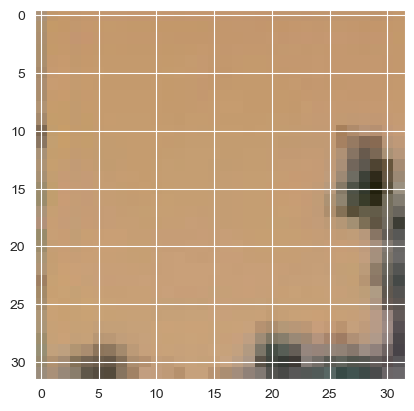

1


In [205]:
from matplotlib import pyplot as plt
plt.imshow(imgs[0])
plt.show()
print(labels[0])

In [206]:
validation_images, validation_labels = train_imgs[:500], train_imgs[:500]

In [207]:
#### Custom Alexnet Implementation
def build_model_AlexNet():
    model = models.Sequential()
    model.add(layers.Conv2D(filters=96, kernel_size=(11,11), strides=(4,4), activation='relu', input_shape=(227,227,3)))
    model.add(layers.MaxPool2D(pool_size=(3,3), strides=(2,2)))
    model.add(layers.Conv2D(filters=256, kernel_size=(5,5), strides=(1,1), activation='relu', padding="same"))
    model.add(layers.MaxPool2D(pool_size=(3,3), strides=(2,2)))
    model.add(layers.Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), activation='relu', padding="same"))
    model.add(layers.Conv2D(filters=384, kernel_size=(1,1), strides=(1,1), activation='relu', padding="same"))
    model.add(layers.Conv2D(filters=256, kernel_size=(1,1), strides=(1,1), activation='relu', padding="same"))
    model.add(layers.MaxPool2D(pool_size=(3,3), strides=(2,2)))
    model.add(layers.Flatten())
    model.add(layers.Dense(4096, activation='relu'))
    model.add(layers.Dense(4096, activation='relu'))
    model.add(layers.Dense(10, activation='softmax'))

    model.compile(optimizer=tf.optimizers.SGD(learning_rate=0.001),
                  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                  metrics=['accuracy'])
    return model

In [208]:
#### Custom CNN Implementation
def build_model_Custom():
    model = models.Sequential()
    model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(img_size,img_size, 3)))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(64, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(64, (3, 3), activation='relu'))
    model.add(layers.Flatten())
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dense(2, activation='softmax'))

    model.compile(optimizer=tf.optimizers.SGD(learning_rate=0.001),
                  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
                  metrics=['accuracy'])
    return model

In [209]:
model = build_model_Custom()
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 30, 30, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 15, 15, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 13, 13, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 6, 6, 64)         0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 4, 4, 64)          36928     
                                                                 
 flatten (Flatten)           (None, 1024)              0

In [210]:
# Implement callback function to stop training
# when accuracy reaches e.g. ACCURACY_THRESHOLD = 0.97
ACCURACY_THRESHOLD = 0.97
class myCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        accuracy = logs["accuracy"]
        if accuracy > ACCURACY_THRESHOLD:
            print("\nReached %2.2f%% accuracy, so stopping training!!" %(ACCURACY_THRESHOLD*100))
            self.model.stop_training = True

callback = myCallback()

In [211]:
history = model.fit(train_imgs, train_labels, epochs=20,validation_data=(test_imgs, test_labels),batch_size=64,callbacks=callback)

Epoch 1/20
222/222 [==============================] - 22s 98ms/step - loss: 1.0806 - accuracy: 0.8424 - val_loss: 0.2210 - val_accuracy: 0.9122
Epoch 2/20
222/222 [==============================] - 23s 104ms/step - loss: 0.2191 - accuracy: 0.9136 - val_loss: 0.1768 - val_accuracy: 0.9307
Epoch 3/20
222/222 [==============================] - 22s 99ms/step - loss: 0.1741 - accuracy: 0.9352 - val_loss: 0.1447 - val_accuracy: 0.9443
Epoch 4/20
222/222 [==============================] - 22s 99ms/step - loss: 0.1466 - accuracy: 0.9458 - val_loss: 0.1324 - val_accuracy: 0.9502
Epoch 5/20
222/222 [==============================] - 22s 98ms/step - loss: 0.1258 - accuracy: 0.9573 - val_loss: 0.1241 - val_accuracy: 0.9533
Epoch 6/20
222/222 [==============================] - 22s 98ms/step - loss: 0.1135 - accuracy: 0.9597 - val_loss: 0.1067 - val_accuracy: 0.9581
Epoch 7/20
222/222 [==============================] - 22s 100ms/step - loss: 0.1018 - accuracy: 0.9652 - val_loss: 0.1327 - val_accurac

111/111 - 1s - loss: 0.0941 - accuracy: 0.9645 - 569ms/epoch - 5ms/step
111/111 [==============================] - 1s 6ms/step


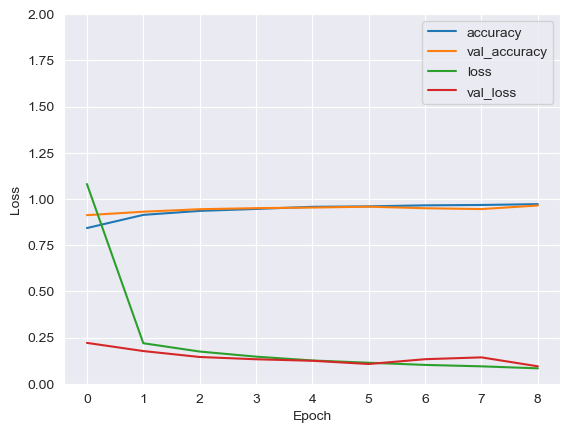

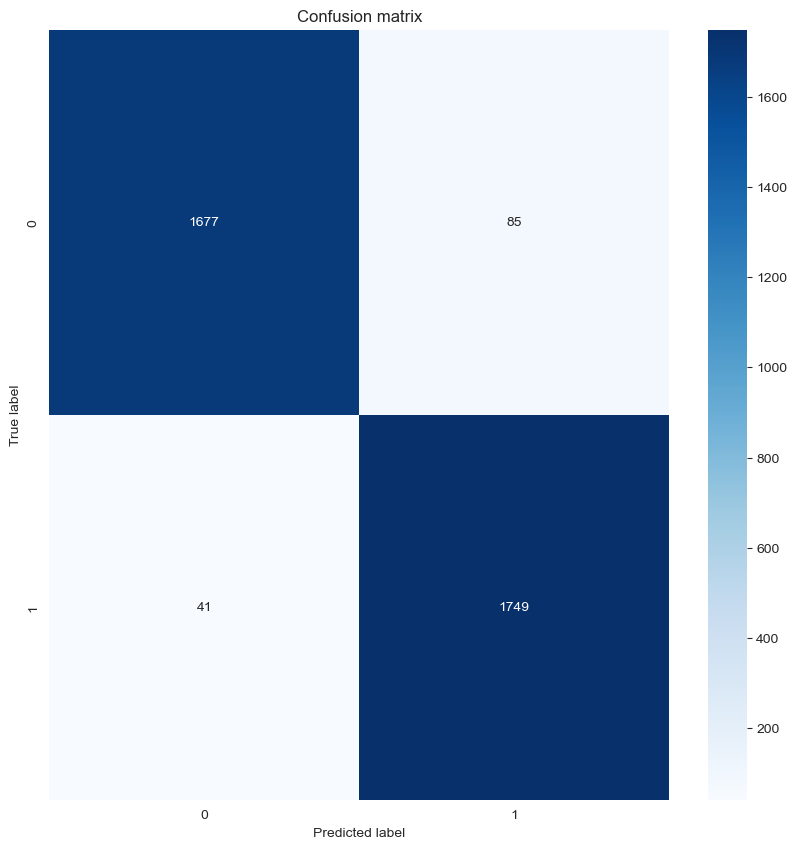

In [212]:
# Evaluating the model
test_loss, test_acc = model.evaluate(test_imgs,  test_labels, verbose=2)

# Saving the model
# model.save('Project_Vehicle.h5')

# Plotting the accuracy and loss
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
# legend on top right
plt.legend(loc='upper right')

plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label = 'val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.ylim([0, 2])
# legend on top right
plt.legend(loc='upper right')

# print confusion matrix with labels using seaborn
predictions = model.predict(test_imgs)
predictions = np.argmax(predictions, axis=1)
cm = confusion_matrix(test_labels, predictions)
plt.figure(figsize=(10,10))
sns.heatmap(cm, annot=True, fmt="d", cmap='Blues')
plt.title("Confusion matrix")
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

keras.backend.clear_session()

In [1]:
#### Defining Function for printing an output
def is_vehicle(modelx, img):
    pred = modelx.predict(img)
    if pred[0][0]>0.95:
        print("Its an automobile (%.5f%%)"%(pred[0][0]*100))
    else:
        print("Its not an automobile (%.5f%%)"%(pred[0][1]*100))

In [214]:
# getting test image location
img_org = cv2.imread("E:/Codes/Deep Learning CV/Project/Dataset/vehicle_images/1633889235234_BMW i8 Protonic 2017 for sale.jpg")
img0 = cv2.resize(img_org,(img_size,img_size))
img=img0.reshape(1,32,32,3)

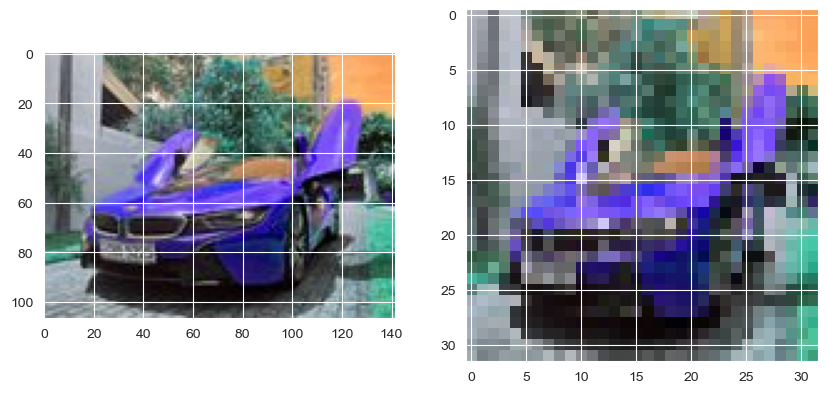

In [215]:
# display test image
fig = plt.figure(figsize=(10, 7))
fig.add_subplot(1,2,1)
plt.imshow(img_org)
fig.add_subplot(1,2,2)
plt.imshow(img0)
plt.show()

In [216]:
is_vehicle(model,img)

1/1 [==============================] - 0s 47ms/step
Its an automobile (99.99850%)


In [217]:
##### Hyperparameter tuning the model (AlexNet)
def build_model_0(hp):
    model = models.Sequential()
    model.add(layers.Conv2D(hp.Int('Conv1',min_value=32, max_value=128), (3, 3), activation='relu', input_shape=(img_size,img_size, 3)))
    model.add(layers.MaxPool2D((3,3),(2,2)))
    model.add(layers.Conv2D(hp.Int('Conv1',min_value=32, max_value=128), (5,5), (1,1), activation='relu', padding="same"))
    model.add(layers.MaxPool2D((3,3), (2,2)))
    model.add(layers.Conv2D(hp.Int('Conv1',min_value=32, max_value=128),(3,3),(1,1), activation='relu', padding="same"))
    model.add(layers.Conv2D(hp.Int('Conv1',min_value=32, max_value=128),(1,1),(1,1), activation='relu', padding="same"))
    model.add(layers.Conv2D(hp.Int('Conv1',min_value=32, max_value=128), (1,1), (1,1), activation='relu', padding="same"))
    model.add(layers.MaxPool2D((3,3),(2,2)))
    model.add(layers.Flatten())
    model.add(layers.Dense(hp.Int('Conv1',min_value=32, max_value=1024), activation='relu'))
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(hp.Int('Conv1',min_value=32, max_value=1024), activation='relu'))
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(2, activation='softmax'))

    model.compile(optimizer=tf.optimizers.SGD(learning_rate=0.001),
                  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
                  metrics=['accuracy'])
    return model

In [218]:
tuner=RandomSearch(build_model_0,objective='val_accuracy',max_trials=5,directory='output',project_name="Vehicle classification")

In [219]:
tuner.search(train_imgs,train_labels,epochs=3,validation_split=0.1)

Trial 5 Complete [00h 02m 29s]
val_accuracy: 0.9437016248703003

Best val_accuracy So Far: 0.9584799408912659
Total elapsed time: 00h 15m 26s
INFO:tensorflow:Oracle triggered exit


In [220]:
op_model=tuner.get_best_models(num_models=1)[0]

In [221]:
op_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 30, 30, 76)        2128      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 76)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 14, 14, 76)        144476    
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 6, 6, 76)         0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 6, 6, 76)          52060     
                                                                 
 conv2d_3 (Conv2D)           (None, 6, 6, 76)          5

In [222]:
# Implement callback function to stop training
# when accuracy reaches e.g. ACCURACY_THRESHOLD = 0.99
ACCURACY_THRESHOLD = 0.99
class myCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        accuracy = logs["accuracy"]
        if accuracy > ACCURACY_THRESHOLD:
            print("\nReached %2.2f%% accuracy, so stopping training!!" %(ACCURACY_THRESHOLD*100))
            self.model.stop_training = True

callback = myCallback()

In [223]:
op_model.fit(train_imgs, train_labels, epochs=10, validation_split=0.1, initial_epoch=3,callbacks=callback)

Epoch 4/10
400/400 [==============================] - 45s 112ms/step - loss: 0.1137 - accuracy: 0.9578 - val_loss: 0.1121 - val_accuracy: 0.9627
Epoch 5/10
400/400 [==============================] - 46s 116ms/step - loss: 0.0884 - accuracy: 0.9690 - val_loss: 0.1066 - val_accuracy: 0.9620
Epoch 6/10
400/400 [==============================] - 45s 113ms/step - loss: 0.0745 - accuracy: 0.9743 - val_loss: 0.0704 - val_accuracy: 0.9789
Epoch 7/10
400/400 [==============================] - 46s 115ms/step - loss: 0.0628 - accuracy: 0.9794 - val_loss: 0.0815 - val_accuracy: 0.9754
Epoch 8/10
400/400 [==============================] - 46s 115ms/step - loss: 0.0567 - accuracy: 0.9815 - val_loss: 0.0674 - val_accuracy: 0.9824
Epoch 9/10
400/400 [==============================] - 45s 113ms/step - loss: 0.0469 - accuracy: 0.9858 - val_loss: 0.1185 - val_accuracy: 0.9662
Epoch 10/10
400/400 [==============================] - 46s 115ms/step - loss: 0.0375 - accuracy: 0.9892 - val_loss: 0.0619 - val_a

In [224]:
#### Testing with garbage image
img_org = cv2.imread("E:\Codes\Deep Learning CV\Project\Dataset\DPCV_Project\\non-vehicles\extra15.png")
img0 = cv2.resize(img_org,(img_size,img_size))
img=img0.reshape(1,32,32,3)

In [ ]:
# display test image
fig = plt.figure(figsize=(10, 7))
fig.add_subplot(1,2,1)
plt.imshow(img_org)
fig.add_subplot(1,2,2)
plt.imshow(img0)
plt.show()

In [225]:
is_vehicle(op_model,img)

1/1 [==============================] - 0s 84ms/step
Its not an automobile (99.99804%)


In [226]:
#### Testing with Car image
img_org = cv2.imread("E:/Codes/Deep Learning CV/Project/Dataset/vehicle_images/1633889235234_BMW i8 Protonic 2017 for sale.jpg")
img0 = cv2.resize(img_org,(img_size,img_size))
img=img0.reshape(1,32,32,3)

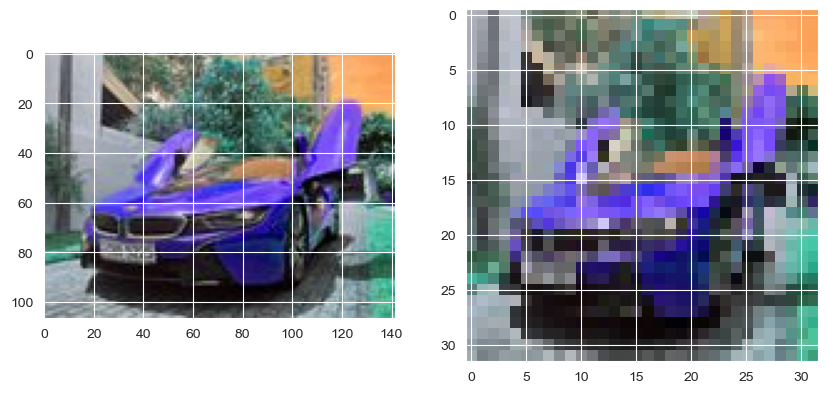

In [227]:
# display test image
fig = plt.figure(figsize=(10, 7))
fig.add_subplot(1,2,1)
plt.imshow(img_org)
fig.add_subplot(1,2,2)
plt.imshow(img0)
plt.show()

In [228]:
is_vehicle(op_model,img)

1/1 [==============================] - 0s 16ms/step
Its an automobile (99.99975%)
